# Capacitated Vehicle Routing Problem

<img src = 'CVRP.png'>
## Problem statement
<b> Suppose you must decide how many vehicles to use to distribute packages in your city on any given day.</b> <br>
Consider the following aspects:
- A list of packages that must necessarily be delivered is available at the beginning of each day.
- Each package has a known weight and volume
- It has a series of vehicles with known weight and volume capacity

## Contraints
- $n$ is the number of clients and $N = {1,..,n} $ : denotes the set of clients
- $V=\{0\}\cup N$ Set of nodes, where $0$ represents the Depot
- $A=\{(i,j)\in V^2 : i\neq j\}$ Set of all arcs in the network
- $c_{i,j}$ cost of transportation from node $i$ to node $j$, where $(i,j)\in A$
- $q_i$ is the amount that has to be delivered to customer at $i \in N$ 
- $Q$ is the Vehicle Capacity

## Decision variables and Formulations

* $x_{i,j}$ = 1 when deciding to travel on the arc (i, j) ∈A (i, j) ∈A; |  0 otherwise
* $u_i$ = cumulative volume on a route to the customer
* $ w_j$ = Accumulated weight on a route to the client
<br>
<br>

Then, the <b> mathematical formulation </b> of the problem is: 

$$\begin{align}
\min \quad & \sum_{(i,j)\in A} c_{ij} x_{ij} \\
\text{s.t.}  \quad & \sum_{j\in V, j\neq i} x_{ij} = 1 && i \in N \\
& \sum_{i\in V, i\neq j} x_{ij} = 1 && j \in N \\
& \text{if} \ x_{ij} = 1 \ \Rightarrow \ u_i + q_j = u_j && i,j \in A : j\neq 0, i\neq 0 \\
& q_i \leq u_i \leq Q && i \in N \\
& x_{ij} \in \{0,1\} && i,j \in A 
\end{align}$$ 


# Implementations

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

# Simulate data

In [12]:
# Create/simulate data
random.seed(142)
n = int(input('Enter number of Clients = ') or 10)  # number of clients
Q = int(input('Enter capacity of vehicles = ') or 15)  # Capacity
N = [i for i in range(1,n+1)]  # Create set of nodes
V = [0] + N  # Add the Wirehouse into the set of nodes
q = {i:np.random.randint(1,10) for i in N}  # Create demands at client loactions/nodes

Enter number of Clients = 7
Enter capacity of vehicles = 15


In [31]:
# Simulate and visualize the network using Eucledian distances
x_cord = np.random.rand(len(V))*400
y_cord = np.random.rand(len(V))*300

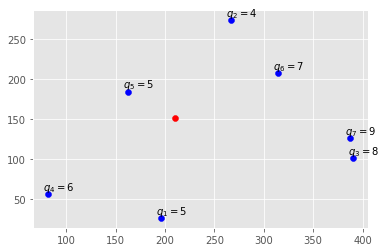

In [32]:
plt.scatter(x_cord[1:], y_cord[1:], c = 'b')
plt.scatter(x_cord[0], y_cord[0], c='r')

for i in N:
    plt.annotate('$q_%d = %d$' % (i,q[i]), (x_cord[i]-5, y_cord[i]+5))
plt.show()

In [33]:
# Create arcs and costs
A = [(i,j) for i in V for j in V if i!=j]
c = {(i,j):np.hypot(x_cord[i]-x_cord[j], y_cord[i]-y_cord[j]) for i,j in A}


# Call CPLEX

In [34]:
from docplex.mp.model import Model
import docplex

In [35]:
# ! pip install docplex

# Create model and decision variables

In [36]:
mdl = Model('CVRP')

In [37]:
x = mdl.binary_var_dict(A, name = 'x')
u = mdl.continuous_var_dict(N, ub = Q, name = 'u')

# Add constraints

In [38]:
mdl.minimize(mdl.sum(c[i,j]*x[i,j] for i,j in A))
mdl.add_constraints(mdl.sum(x[i,j] for j in V if j!=i)== 1 for i in N)
mdl.add_constraints(mdl.sum(x[i,j] for i in V if i!=j)== 1 for j in N)
mdl.add_indicator_constraints(list(mdl.indicator_constraint(x[i,j], u[i]+q[j]==u[j]) for i,j in A if i!=0 and j!=0))
mdl.add_constraints(u[i]>=q[i] for i in N)

[docplex.mp.LinearConstraint[](u_1,GE,5),
 docplex.mp.LinearConstraint[](u_2,GE,4),
 docplex.mp.LinearConstraint[](u_3,GE,8),
 docplex.mp.LinearConstraint[](u_4,GE,6),
 docplex.mp.LinearConstraint[](u_5,GE,5),
 docplex.mp.LinearConstraint[](u_6,GE,7),
 docplex.mp.LinearConstraint[](u_7,GE,9)]

# Solve

In [39]:
# solution = mdl.solve(log_output = True)
solution = mdl.solve(url = input('Enter the url = '),
                     key =input('Enter the API key = '))
print(solution)

Enter the url = 'https://api-oaas.docloud.ibmcloud.com/job_manager/rest/v1/'
Enter the API key = 'api_27b5a922-07e8-445d-b6da-ef27c4421c91'
solution for: CVRP
objective: 1457.19
x_0_1=1
x_0_2=1
x_0_5=1
x_0_6=1
x_1_4=1
x_2_7=1
x_3_0=1
x_4_0=1
x_5_0=1
x_6_3=1
x_7_0=1
u_1=5.000
u_2=4.000
u_3=15.000
u_4=11.000
u_5=5.000
u_6=7.000
u_7=13.000



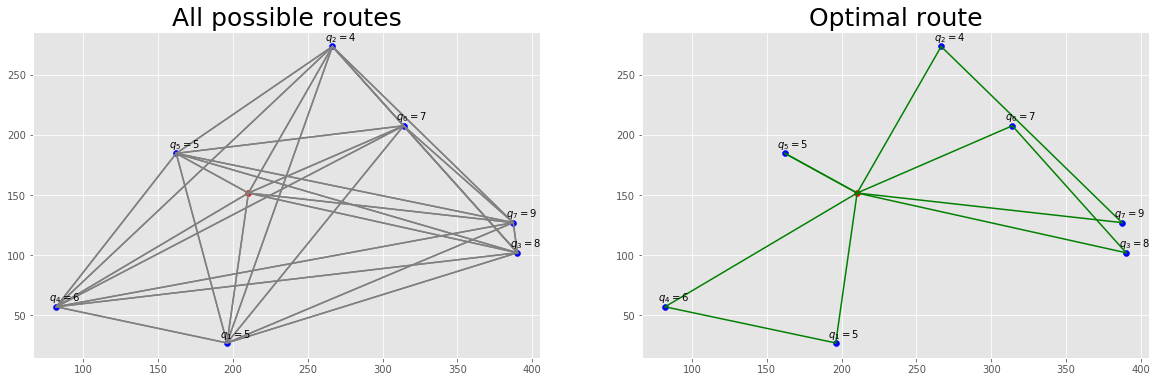

In [40]:
# optimal path -  active paths
active_arcs = [a for a in A if x[a].solution_value > 0.9]

# Visualize / Plotting
f, (ax1,ax2) = plt.subplots(1,2, figsize = (20, 6))
# all possible paths - ax1
ax1.scatter(x_cord[1:], y_cord[1:], c = 'b')
ax1.scatter(x_cord[0], y_cord[0], c='r')
ax1.set_title('All possible routes', fontsize = 25)

for i in N:
    ax1.annotate('$q_%d = %d$' % (i,q[i]), (x_cord[i]-5, y_cord[i]+5))
for i,j in A:
    ax1.plot([x_cord[i],x_cord[j]], [y_cord[i], y_cord[j]], c = 'grey')
    
# Optimal path - ax2
ax2.scatter(x_cord[1:], y_cord[1:], c = 'b')
ax2.scatter(x_cord[0], y_cord[0], c='r')
ax2.set_title('Optimal route', fontsize = 25)

for i in N:
    ax2.annotate('$q_%d = %d$' % (i,q[i]), (x_cord[i]-5, y_cord[i]+5))
for i,j in active_arcs:
    ax2.plot([x_cord[i],x_cord[j]], [y_cord[i], y_cord[j]], c = 'g')
plt.show()

# Variation of subtours with change in capacity

In [49]:
def CVRP():
    Q = int(input('Enter capacity of vehicles = ') or 15)
    mdl = Model('CVRP')
    x = mdl.binary_var_dict(A, name = 'x')
    u = mdl.continuous_var_dict(N, ub = Q, name = 'u')

    mdl.minimize(mdl.sum(c[i,j]*x[i,j] for i,j in A))
    mdl.add_constraints(mdl.sum(x[i,j] for j in V if j!=i)== 1 for i in N)
    mdl.add_constraints(mdl.sum(x[i,j] for i in V if i!=j)== 1 for j in N)
    mdl.add_indicator_constraints(list(mdl.indicator_constraint(x[i,j], u[i]+q[j]==u[j]) for i,j in A if i!=0 and j!=0))
    mdl.add_constraints(u[i]>=q[i] for i in N)

    solution = mdl.solve(url = 'https://api-oaas.docloud.ibmcloud.com/job_manager/rest/v1/',
                         key ='api_27b5a922-07e8-445d-b6da-ef27c4421c91')


    # optimal path -  active paths
    active_arcs = [a for a in A if x[a].solution_value > 0.9]

    plt.scatter(x_cord[1:], y_cord[1:], c = 'b')
    plt.scatter(x_cord[0], y_cord[0], c='r')
    plt.title('Optimal route with %s clients'%Q, fontsize = 20)

    for i in N:
        plt.annotate('$q_%d = %d$' % (i,q[i]), (x_cord[i]-5, y_cord[i]+5))
    for i,j in active_arcs:
        plt.plot([x_cord[i],x_cord[j]], [y_cord[i], y_cord[j]], c = 'g')
    plt.show()

Enter capacity of vehicles = 10


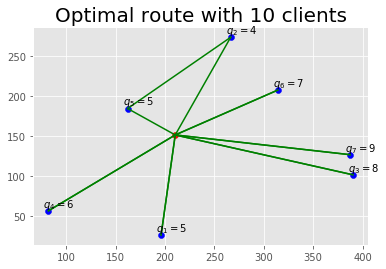

Enter capacity of vehicles = 15


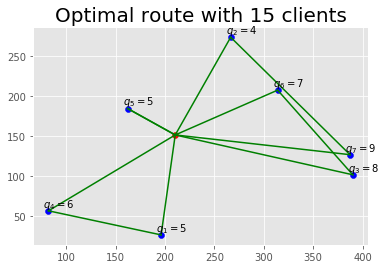

Enter capacity of vehicles = 20


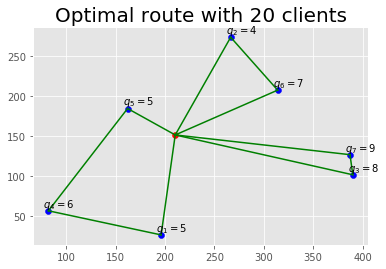

(None, None, None)

In [50]:
CVRP(), CVRP() ,CVRP()

Enter capacity of vehicles = 100


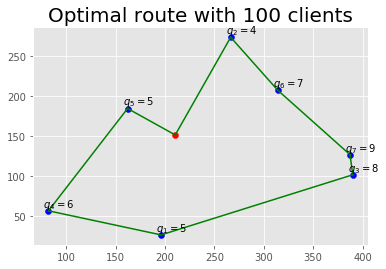

In [51]:
CVRP()